In [1]:
# Shift+Enter to run a cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# This line makes plots show up nicely
%matplotlib inline

In [2]:
# Load the life expectancy data
life_df = pd.read_csv('data/life_expectancy.csv', skiprows=4)

# Show first 5 rows
life_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,64.049000,64.215000,64.602000,64.944000,65.303000,65.615000,...,75.540000,75.620000,75.880000,76.019000,75.406000,73.655000,76.226000,76.353000,NaN,NaN
1,Africa Eastern and Southern,AFE,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,44.169658,44.468838,44.877890,45.160583,45.535695,45.770723,...,62.167981,62.591275,63.330691,63.857261,63.766484,62.979999,64.487020,65.146291,NaN,NaN
2,Afghanistan,AFG,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,32.799000,33.291000,33.757000,34.201000,34.673000,35.124000,...,62.646000,62.406000,62.443000,62.941000,61.454000,60.417000,65.617000,66.035000,NaN,NaN
3,Africa Western and Central,AFW,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,37.779636,38.058956,38.681792,38.936918,39.194580,39.479784,...,56.392452,56.626439,57.036976,57.149847,57.364425,57.362572,57.987813,58.855722,NaN,NaN
4,Angola,AGO,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,37.933000,36.902000,37.168000,37.419000,37.704000,37.968000,...,61.619000,62.122000,62.622000,63.051000,63.116000,62.958000,64.246000,64.617000,NaN,NaN


In [3]:
# Dimensions of DataFrame
print("Life Expectancy DataFrame Shape:", life_df.shape)

# Get summary of DataFrame
life_df.info

Life Expectancy DataFrame Shape: (266, 70)


<bound method DataFrame.info of                     Country Name Country Code  \
0                          Aruba          ABW   
1    Africa Eastern and Southern          AFE   
2                    Afghanistan          AFG   
3     Africa Western and Central          AFW   
4                         Angola          AGO   
..                           ...          ...   
261                       Kosovo          XKX   
262                  Yemen, Rep.          YEM   
263                 South Africa          ZAF   
264                       Zambia          ZMB   
265                     Zimbabwe          ZWE   

                              Indicator Name  Indicator Code       1960  \
0    Life expectancy at birth, total (years)  SP.DYN.LE00.IN  64.049000   
1    Life expectancy at birth, total (years)  SP.DYN.LE00.IN  44.169658   
2    Life expectancy at birth, total (years)  SP.DYN.LE00.IN  32.799000   
3    Life expectancy at birth, total (years)  SP.DYN.LE00.IN  37.779636   
4   

In [4]:
# Health Expenditure
health_exp_df = pd.read_csv('data/health_expenditure.csv', skiprows=4)
health_exp_df.head()

print("Health Expenditure DataFrame Shape:", health_exp_df.shape)
health_exp_df.info

Health Expenditure DataFrame Shape: (266, 70)


<bound method DataFrame.info of                     Country Name Country Code  \
0                          Aruba          ABW   
1    Africa Eastern and Southern          AFE   
2                    Afghanistan          AFG   
3     Africa Western and Central          AFW   
4                         Angola          AGO   
..                           ...          ...   
261                       Kosovo          XKX   
262                  Yemen, Rep.          YEM   
263                 South Africa          ZAF   
264                       Zambia          ZMB   
265                     Zimbabwe          ZWE   

                                        Indicator Name     Indicator Code  \
0    Current health expenditure per capita (current...  SH.XPD.CHEX.PC.CD   
1    Current health expenditure per capita (current...  SH.XPD.CHEX.PC.CD   
2    Current health expenditure per capita (current...  SH.XPD.CHEX.PC.CD   
3    Current health expenditure per capita (current...  SH.XPD.CHEX.PC.

In [5]:
# Physicians
physicians_df = pd.read_csv('data/physicians.csv', skiprows=4)
physicians_df.head()

print("Physicians DataFrame Shape:", physicians_df.shape)
physicians_df.info

Physicians DataFrame Shape: (266, 70)


<bound method DataFrame.info of                     Country Name Country Code                 Indicator Name  \
0                          Aruba          ABW  Physicians (per 1,000 people)   
1    Africa Eastern and Southern          AFE  Physicians (per 1,000 people)   
2                    Afghanistan          AFG  Physicians (per 1,000 people)   
3     Africa Western and Central          AFW  Physicians (per 1,000 people)   
4                         Angola          AGO  Physicians (per 1,000 people)   
..                           ...          ...                            ...   
261                       Kosovo          XKX  Physicians (per 1,000 people)   
262                  Yemen, Rep.          YEM  Physicians (per 1,000 people)   
263                 South Africa          ZAF  Physicians (per 1,000 people)   
264                       Zambia          ZMB  Physicians (per 1,000 people)   
265                     Zimbabwe          ZWE  Physicians (per 1,000 people)   

     In

In [6]:
# Identify which columns are years
year_columns = [col for col in life_df.columns if col.isdigit() and len(col) == 4]

print("First 10 year columns:", year_columns[:10])
print("Number of year columns found:", len(year_columns))

First 10 year columns: ['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969']
Number of year columns found: 65


In [7]:
# Select the columns: Country names, codes, and all the year columns
life_long = life_df.melt(
    id_vars=['Country Name', 'Country Code'], # These stay as columns
    value_vars=year_columns,           # These are all the year columns
    var_name='Year',                          # New year column name
    value_name='Life_Exp'                     # New value column name
)

print("Life Expectancy (Long Format) Shape:", life_long.shape)
life_long.head()

Life Expectancy (Long Format) Shape: (17290, 4)


,Country Name,Country Code,Year,Life_Exp
0,Aruba,ABW,1960,64.049000
1,Africa Eastern and Southern,AFE,1960,44.169658
2,Afghanistan,AFG,1960,32.799000
3,Africa Western and Central,AFW,1960,37.779636
4,Angola,AGO,1960,37.933000


In [8]:
# Melt the health expenditure data
health_exp_long = health_exp_df.melt(
    id_vars=['Country Name', 'Country Code'],
    value_vars=year_columns,
    var_name='Year',
    value_name='Health_Exp_PC' # PC for Per Capita
)
print("Health Expenditure (Long Format) Shape:", health_exp_long.shape)

# Melt the physicians data
physicians_long = physicians_df.melt(
    id_vars=['Country Name', 'Country Code'],
    value_vars=year_columns,
    var_name='Year',
    value_name='Physicians'
)
print("Physicians (Long Format) Shape:", physicians_long.shape)

Health Expenditure (Long Format) Shape: (17290, 4)
Physicians (Long Format) Shape: (17290, 4)


In [9]:
# Merge Life Expectancy and Health Expenditure
merged_df = pd.merge(life_long, health_exp_long, on=['Country Name', 'Country Code', 'Year'])

# Merge Physicians data
master_df = pd.merge(merged_df, physicians_long, on=['Country Name', 'Country Code', 'Year'])

print("Master DataFrame Shape:", master_df.shape)
master_df.head(10)

Master DataFrame Shape: (17290, 6)


,Country Name,Country Code,Year,Life_Exp,Health_Exp_PC,Physicians
0,Aruba,ABW,1960,64.049000,NaN,NaN
1,Africa Eastern and Southern,AFE,1960,44.169658,NaN,NaN
2,Afghanistan,AFG,1960,32.799000,NaN,0.035
3,Africa Western and Central,AFW,1960,37.779636,NaN,NaN
4,Angola,AGO,1960,37.933000,NaN,0.067
5,Albania,ALB,1960,56.413000,NaN,0.276
6,Andorra,AND,1960,72.094000,NaN,NaN
7,Arab World,ARB,1960,44.794056,NaN,NaN
8,United Arab Emirates,ARE,1960,50.651000,NaN,NaN
9,Argentina,ARG,1960,64.242000,NaN,1.351


In [10]:
# Check the number of missing values in each column

master_df.isnull().sum()

Country Name         0
Country Code         0
Year                 0
Life_Exp           364
Health_Exp_PC    11829
Physicians       11973
dtype: int64

In [11]:
master_df['Year'] = master_df['Year'].astype(int)

# Check the new master DataFrame
print("Master DataFrame Shape:", master_df.shape)
print("Year column data type:", master_df['Year'].dtype)
master_df.head()

Master DataFrame Shape: (17290, 6)
Year column data type: int64


,Country Name,Country Code,Year,Life_Exp,Health_Exp_PC,Physicians
0,Aruba,ABW,1960,64.049000,NaN,NaN
1,Africa Eastern and Southern,AFE,1960,44.169658,NaN,NaN
2,Afghanistan,AFG,1960,32.799000,NaN,0.035
3,Africa Western and Central,AFW,1960,37.779636,NaN,NaN
4,Angola,AGO,1960,37.933000,NaN,0.067


In [12]:
# Filter for years from 2000 onwards
df_recent = master_df[master_df['Year'] >= 2000]
print("Shape of recent data:", df_recent.shape)

Shape of recent data: (6650, 6)


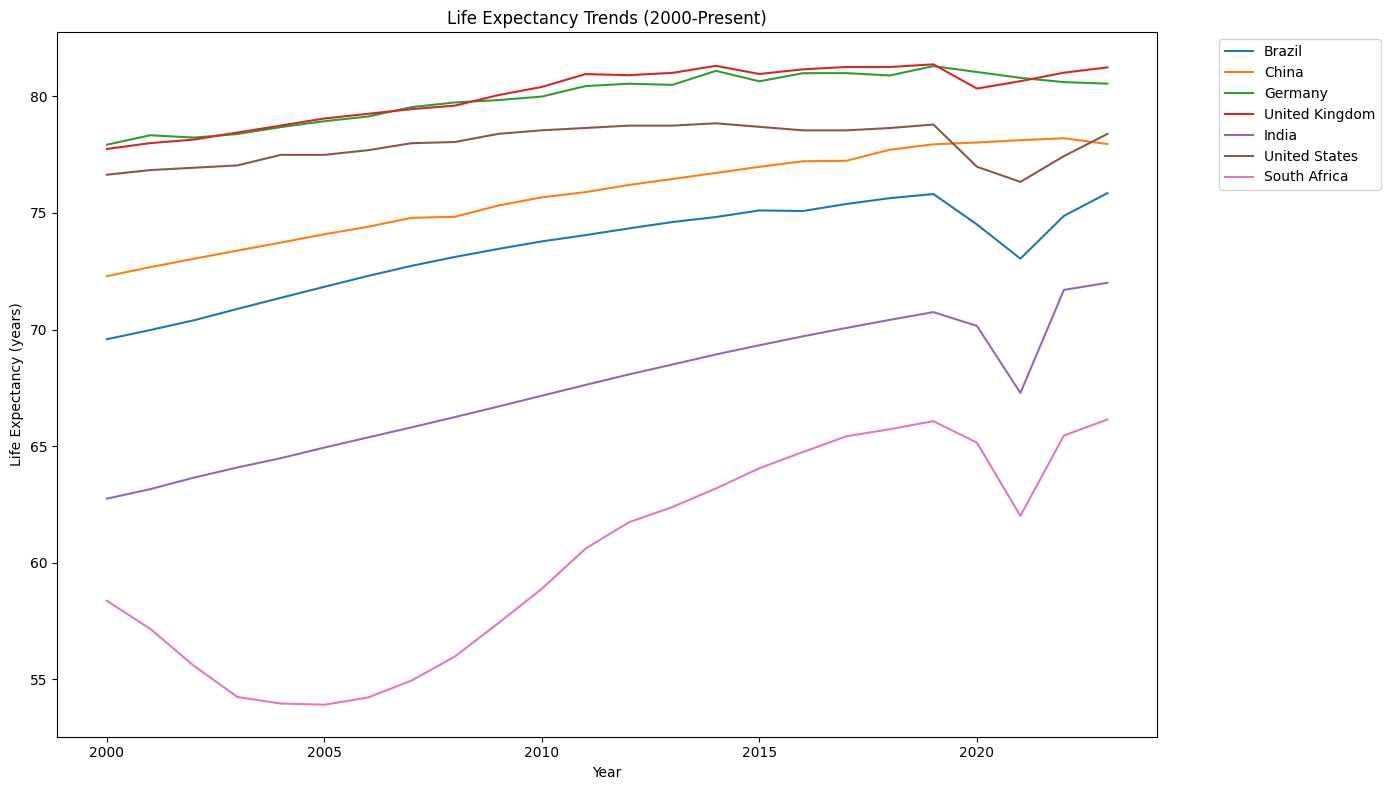

In [13]:
# List of countries to compare
countries_to_plot = ['United Kingdom', 'United States', 'China', 'India', 'Germany', 'Brazil', 'South Africa']
plot_df = df_recent[df_recent['Country Name'].isin(countries_to_plot)]

# Create the plot
plt.figure(figsize=(14, 8)) # Makes the plot bigger
sns.lineplot(data=plot_df, x='Year', y='Life_Exp', hue='Country Name', errorbar=None)
plt.title('Life Expectancy Trends (2000-Present)')
plt.ylabel('Life Expectancy (years)')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Puts legend outside the plot
plt.tight_layout() # Adjusts layout to fit everything
plt.show()

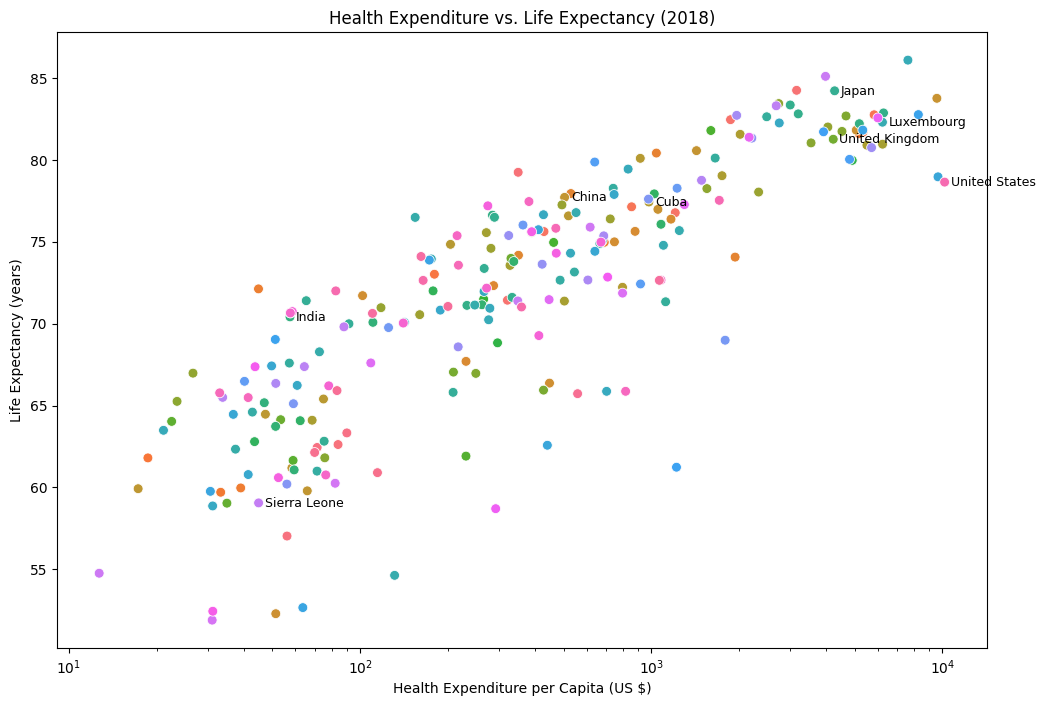

In [14]:
# Filter for a specific year
df_2018 = df_recent[df_recent['Year'] == 2018]

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df_2018, x='Health_Exp_PC', y='Life_Exp', hue='Country Name', legend=False, s=50)

# Get current axes for coordinate transformation
ax = plt.gca()

# Add country labels with better positioning for log scale
for line in range(0, df_2018.shape[0]):
    country = df_2018.iloc[line]['Country Name']
    # Only label specific countries to avoid clutter
    if country in ['United States', 'China', 'India', 'Luxembourg', 'Japan', 'Cuba', 'Sierra Leone', 'United Kingdom']:
        x_val = df_2018.iloc[line]['Health_Exp_PC']
        y_val = df_2018.iloc[line]['Life_Exp']
        
        # For log scale, we'll use a small multiplicative offset instead of additive
        # This will work better across the entire range of values
        text = ax.text(x_val * 1.05,
                       y_val, 
                       country, 
                       fontsize=9,
                       ha='left',   # Horizontal alignment to left
                       va='center') # Vertical alignment to center

plt.title('Health Expenditure vs. Life Expectancy (2018)')
plt.xlabel('Health Expenditure per Capita (US $)')
plt.ylabel('Life Expectancy (years)')
plt.xscale('log')
plt.show()

In [15]:
# Find which years have at least some complete data for all three metrics
complete_data_by_year = []
for year in sorted(df_recent['Year'].unique(), reverse=True):
    year_data = df_recent[df_recent['Year'] == year]
    complete_count = len(year_data.dropna(subset=['Life_Exp', 'Health_Exp_PC', 'Physicians']))
    complete_data_by_year.append((year, complete_count))
    
    if complete_count >= 30:
        most_recent_valid_year = year
        break

print("Complete data by year:")
for year, count in complete_data_by_year:
    print(f"{year}: {count} countries with complete data")
    
print(f"\nUsing year: {most_recent_valid_year}")

# Filter for this year and get complete data
df_recent_year = df_recent[df_recent['Year'] == most_recent_valid_year]
df_clean = df_recent_year.dropna(subset=['Life_Exp', 'Health_Exp_PC', 'Physicians'])

print(f"Number of countries with complete data for {most_recent_valid_year}: {len(df_clean)}")

# Create the interactive scatter plot
fig_scatter = px.scatter(df_clean,
                         x='Health_Exp_PC',
                         y='Life_Exp',
                         size='Physicians',
                         hover_name='Country Name',
                         hover_data=['Country Code', 'Health_Exp_PC', 'Life_Exp', 'Physicians'],
                         title=f'Health Expenditure vs. Life Expectancy ({most_recent_valid_year})',
                         labels={'Health_Exp_PC': 'Health Expenditure per Capita (US $)',
                                 'Life_Exp': 'Life Expectancy (years)',
                                 'Physicians': 'Physicians per 1k'},
                         log_x=True,
                         width=1000,
                         height=600)

# Make the hover tool show more precise numbers
fig_scatter.update_traces(hovertemplate='<b>%{hovertext}</b><br>' +
                                        'Health Expenditure: $%{x:,.0f}<br>' +
                                        'Life Expectancy: %{y:.1f} years<br>' +
                                        'Physicians: %{marker.size:.2f} per 1k' +
                                        '<extra></extra>')

fig_scatter.show()

Complete data by year:
2024: 0 countries with complete data
2023: 0 countries with complete data
2022: 61 countries with complete data

Using year: 2022
Number of countries with complete data for 2022: 61


In [16]:
from scipy import stats

# Calculate Pearson's r for the 2022 data
df_2022_clean = df_clean[['Health_Exp_PC', 'Life_Exp']].dropna() # Ensure we're using the same cleaned dataset

pearson_r, p_value = stats.pearsonr(df_2022_clean['Health_Exp_PC'], df_2022_clean['Life_Exp'])

print(f"Pearson's r (Correlation Coefficient): {pearson_r:.3f}")
print(f"P-value: {p_value:.3g}")

# Interpret the strength
if abs(pearson_r) >= 0.7:
    strength = "strong"
elif abs(pearson_r) >= 0.5:
    strength = "moderate"
elif abs(pearson_r) >= 0.3:
    strength = "weak"
else:
    strength = "very weak, or no"

direction = "positive" if pearson_r > 0 else "negative"

print(f"\nInterpretation: There is a {strength} {direction} linear correlation between health expenditure and life expectancy.")

Pearson's r (Correlation Coefficient): 0.723
P-value: 4.82e-11

Interpretation: There is a strong positive linear correlation between health expenditure and life expectancy.


In [17]:
# Filter for countries with similar health expenditure to the UK (~$5000)
# Let's look at countries spending between $4000 and $6000
peer_group = df_clean[(df_clean['Health_Exp_PC'] >= 4000) & (df_clean['Health_Exp_PC'] <= 6000)]

# Sort this peer group by Physicians per 1k to see the UK's rank
peer_group_sorted = peer_group.sort_values('Physicians', ascending=False)
print(peer_group_sorted[['Country Name', 'Health_Exp_PC', 'Life_Exp', 'Physicians']].to_string())

         Country Name  Health_Exp_PC   Life_Exp  Physicians
16506         Austria    5851.962402  81.295122       5.508
16607          Israel    4223.872559  82.700000       3.713
16672     New Zealand    4804.377930  81.958537       3.574
16573  United Kingdom    5035.617188  81.011220       3.174


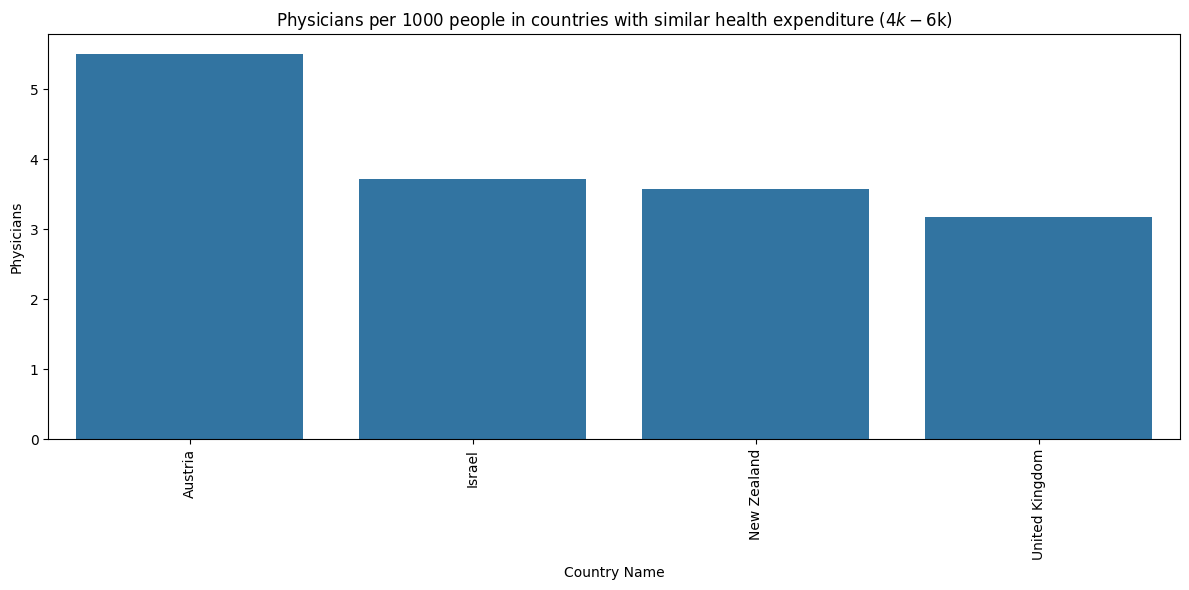

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(data=peer_group_sorted, x='Country Name', y='Physicians')
plt.xticks(rotation=90) # Rotate country names so they're readable
plt.title('Physicians per 1000 people in countries with similar health expenditure ($4k-$6k)')
plt.tight_layout()
plt.show()

In [19]:
# Create a choropleth map for Life Expectancy in 2022
fig_map = px.choropleth(df_clean,
                    locations="Country Code",
                    color="Life_Exp",            # This column determines the color
                    hover_name="Country Name",   # Shows on hover
                    hover_data=["Health_Exp_PC", "Physicians"], # Additional data on hover
                    color_continuous_scale=px.colors.sequential.Plasma, # Color scale
                    title='Global Life Expectancy (2022)',
                    labels={'Life_Exp': 'Life Expectancy (years)'}, # Label for the color scale
                    width=1000,
                    height=600)

# Improve the hover template to show precise values
fig_map.update_traces(hovertemplate='<b>%{hovertext}</b><br>' +
                                    'Life Expectancy: %{z:.1f} years<br>' +
                                    'Health Expenditure: $%{customdata[0]:,.0f}<br>' +
                                    'Physicians: %{customdata[1]:.2f} per 1k' +
                                    '<extra></extra>')

fig_map.show()

In [20]:
# Export the interactive plots to HTML files
fig_map.write_html("docs/map_plot.html")
fig_scatter.write_html("docs/scatter_plot.html")

print("Interactive HTML files have been saved to the 'docs' folder!")

Interactive HTML files have been saved to the 'docs' folder!


In [21]:
# Import the necessary library for saving static images
import plotly.io as pio

# Create the 'images' directory if it doesn't exist
import os
if not os.path.exists('images'):
    os.makedirs('images')

# Save the scatter plot as a high-resolution PNG
pio.write_image(fig_scatter, 'images/health_vs_life_exp_2022.png', 
                width=1000, height=600, scale=2)  # scale=2 makes it higher resolution

# Save the map as a high-resolution PNG
pio.write_image(fig_map, 'images/global_life_expectancy_map_2022.png',
                width=1000, height=600, scale=2)

print("Static image files have been created in the 'images' folder!")

Static image files have been created in the 'images' folder!
